# A2: Module 3

The folder contains CT scans for a selection of 40 patients of lung cancer from the public
dataset LIDC-IDR

The images are provided in NIfTI format and there is one NIfTI (.nii) file for the scan (one
per patient) and one file for the segmentation of a lung nodule.





## Exercise 3.1: Image segmentation

Open the NIfTI files and create one Numpy array per patient scan and one per
segmentation mask. [Hint: you can use existing Python libraries such as
SimpleITK or nibabel.]. Find the range of voxels (3D pixels) in which the
segmentation exists for each patient. Create a numpy array with a subvolume of the
images by increasing 30 voxels in the x and y directions in both senses (min and
max) and 5 in the z direction.

In [1]:
import nibabel as nib
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd

# The segmentation masks are binary images, that the doctor has stated what is cancer and what is not.
# The mask is a 3D volume that contains three dimensions, the x y and z dimension. 
# x, y are the coordinates on the image, and z is the slice



I think it is interesting to plot the slice with the most counts of cancerous tissue. I will make a function to find this slice below:

In [2]:
def find_slice(mask):
    """Prints the slice index with the most non-zero pixels

    args: mask 
    
    """
    non_zero_counts = []
    for z in range(mask.shape[2]):
        count = np.count_nonzero(mask[:, :, z])
        non_zero_counts.append(count)

    # Get index of slice with maximum count
    z0 = np.argmax(non_zero_counts)
    print(f"slice {z0} has the most non-zero pixels")
    
    return z0

Before I begin, let me visualise what a scan and mask looks like. I chose scan/mask 11 randomly, and I also want to see whether my slice find slice function works.

slice 65 has the most non-zero pixels


Text(0.5, 1.0, 'Mask')

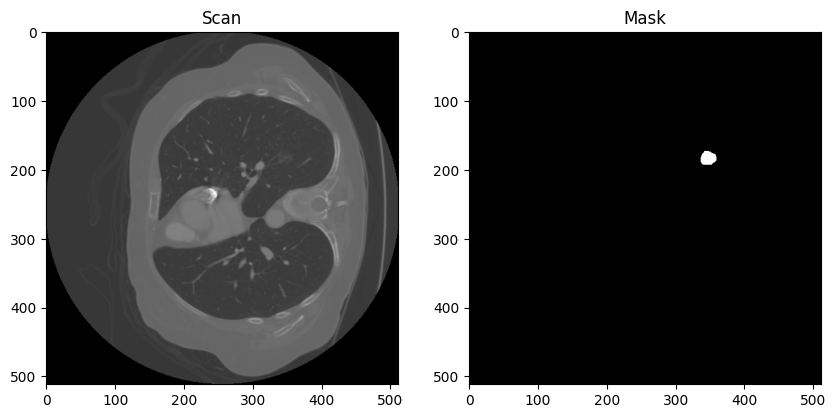

In [3]:


case1_scan = 'files/case_11.nii'
case1_mask = 'files/case_11_mask.nii'

scan1 = nib.load(case1_scan).get_fdata()
mask1 = nib.load(case1_mask).get_fdata()

z0 = find_slice(mask1)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(scan1[:, :, z0], cmap='gray')
ax[0].set_title('Scan')
ax[1].imshow(mask1[:, :, z0], cmap='gray')
ax[1].set_title('Mask')

# Find the slice with the most non-zero pixels in the mask


To create a subvolume, I first loaded the dataset files by separating them into scans and masks, based on whether the filename contained the substring "mask". I then extracted the base patient ID from each scan filename by removing the .nii extension, and constructed the expected corresponding mask filename by appending _mask.nii.

I checked whether these expected masks I have constructed actually matches the list of masks. If so, I constructed the full file paths for both the scan and mask, loaded them using nibabel, and converted them to NumPy arrays using .get_fdata(). These were then stored in a dictionary patients_dict, where the key was the patient ID in common and the value was a list containing the scan and corresponding mask. This allowed me to organize and access paired data volumes efficiently for further processing.

In [4]:

scans = []
masks = []

# Separate scans and masks
for file in os.listdir('files/.'):
    if file.endswith('.nii'):
        if 'mask' in file:
            masks.append(file)
        elif 'case' in file:
            scans.append(file)

# Dictionary to store scans and masks per patient
patients_dict = {}

for scan in scans:
    base_id = scan.replace('.nii', '')  # Remove '.nii' to get patient ID
    mask = base_id + '_mask.nii'  # Expected mask filename
    # I change the scan name to match the mask name
    # now I will check whether this matched name exists in the masks list.
    
    #Now that I made an expected mask name for each scan, I will see if this expected mask name is in the masks list.
    if mask in masks:  
        
        #identify the scan/mask path for that particular scan or mask
        scan_path = os.path.join('files', scan) 
        mask_path = os.path.join('files', mask)
        
        #I will load the data
        loaded_scan = nib.load(scan_path).get_fdata()
        loaded_mask = nib.load(mask_path).get_fdata()


        # Store scan and mask as a tuple in the dictionary, for that particular id they have in common.
        patients_dict[base_id] = [loaded_scan, loaded_mask]

    
# .get_fdata() turns .nii file into numpy array (float64 type)
#structure of patients_dict is a patientid as a key, then [scan,mask] in a list.

Now that I have created the dictionary, I would like to create a subvolumes dictionary. A subvolume is essentially a cropped visualisation of my volume. For example, my 3D cube of lung images will be shrunk down according to where the lung tumour is present. I make sure to leave 30 voxels in the x and y direction and 5 voxels in the z direction.

In [5]:
# I have a mask, and it has 1s and 0s. Get the range of voxels that shows 1s in the x direction, y direction and z direction.

    #first i make a mask with the same shape as my 

subvolumes_dict = {}

#find the segmented regions of the mask.
for key in patients_dict.keys(): # I loop through the keys, which are the patient ids
    
    mask = patients_dict[key][1] #extract the mask and scan
    scan = patients_dict[key][0]
    
    non_zero_voxels = np.argwhere(mask) #This gives me a list of coordinates from the mask, where it is non zero

    x_min, y_min, z_min = non_zero_voxels.min(axis=0) #find the smallest x, y, z from ALL the identified pixels
    #This does not have to be all from the same pixel. it is just the OVERALL smallest, so creating a bounding box corner.
    # Then expand this bounding volume to account for padding
    x_max, y_max, z_max = non_zero_voxels.max(axis=0)

    #Add the extra padding as instructed
    x_min = x_min - 30
    y_min = y_min - 30
    z_min = z_min - 5

    x_max = x_max + 30
    y_max = y_max + 30
    z_max = z_max + 5
    
    # Create the actual subvolumes by slicing
    subvolume_scan = scan[x_min:x_max, y_min:y_max, z_min:z_max]
    subvolume_mask = mask[x_min:x_max, y_min:y_max, z_min:z_max]

    # Store cropped subvolumes
    subvolumes_dict[key] = [subvolume_scan, subvolume_mask]

 Create your own processing-based segmentation function using a simple
thresholding algorithm (do not use supervised machine learning). Apply your
algorithm to the subvolumes created in the previous step. To do so, find the
min/max of the intensities corresponding to voxels inside the segmentation to set a
min/max threshold.

In [6]:
def threshold_segmentation(image_to_be_thresholded, scan, mask):
    """
    Applies a simple intensity-based thresholding algorithm to segment a region of interest.
    
    The method uses the intensity values from within the tumor region (as defined by the ground truth mask) 
    to establish a minimum and maximum intensity range. It then applies this threshold to the 
    provided image (typically a subvolume) to generate a binary segmentation mask.

    Args:
        image_to_be_thresholded (numpy array): The image on which thresholding is applied. 
                                               This is typically a subvolume of the full scan.
        scan (numpy array): The subvolume CT image from which intensity thresholds are derived.
        mask (numpy array): The binary ground truth mask corresponding to the same subvolume.

    Returns:
        segmented_image (numpy array): A binary mask where voxels within the tumor intensity 
                                       range are labeled as 1, and all others as 0.
    """

    # Obtaining all the voxels in the scan where the mask is non-zero (tumor is present)
    inside_values = scan[mask > 0]

    #Find the min and max intensities of these voxels
    min_val = inside_values.min()
    max_val = inside_values.max()

    #If voxel in image is within range of tumor values, then set to 1.
    segmented_image = ((image_to_be_thresholded >= min_val) & 
                       (image_to_be_thresholded <= max_val)).astype(np.uint8)

    return segmented_image



Now, I will apply the threshold segementation function to all my subvolumes. I have appended this segmented image as the third element in the list.
[
    scan,             # index 0
    mask,             # index 1
    segmented_image   # index 2
]

In [7]:
for key in subvolumes_dict.keys():
    scan = subvolumes_dict[key][0]
    mask = subvolumes_dict[key][1]
    segmented_image = threshold_segmentation(scan, scan, mask)
    subvolumes_dict[key].append(segmented_image)

I decided to plot two examples to showcase the variability in performance of the thresholding function. Below is an example of a bad segementation, where it does not match up to the ground truth.

slice 11 has the most non-zero pixels


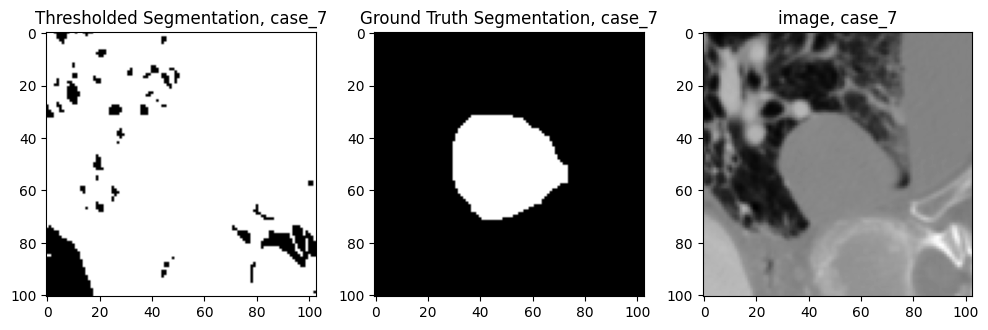

In [8]:


thresholded_segmentations = subvolumes_dict['case_7'][2]
ground_truth_segmentation = subvolumes_dict['case_7'][1]
scan_sub = subvolumes_dict['case_7'][0]

z_0 = find_slice(ground_truth_segmentation)
fig, ax = plt.subplots(1,3,figsize=(10, 5))

ax[0].imshow(thresholded_segmentations[:,:,z_0], cmap='gray')
ax[0].set_title('Thresholded Segmentation, case_7')
ax[1].imshow(ground_truth_segmentation[:,:,z_0], cmap='gray')
ax[1].set_title('Ground Truth Segmentation, case_7')
ax[2].imshow(scan_sub[:,:,z_0], cmap='gray')
ax[2].set_title('image, case_7')

plt.tight_layout()


Below is an example of a good segementation, where it matches up better with the ground truth.

slice 5 has the most non-zero pixels


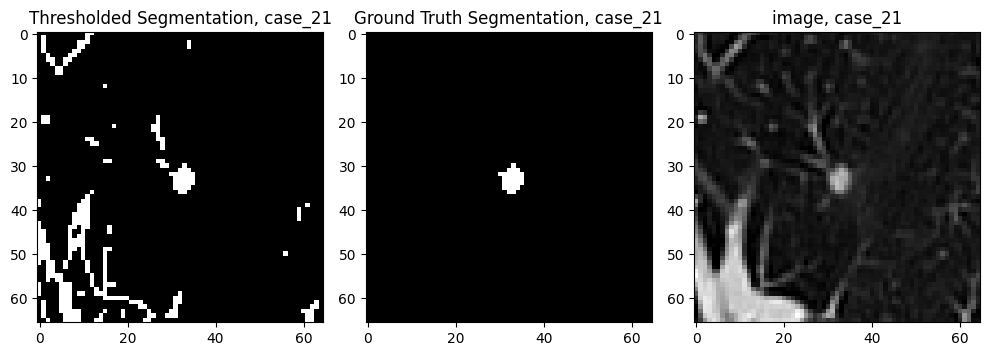

In [9]:

thresholded_segmentations = subvolumes_dict['case_21'][2]
ground_truth_segmentation = subvolumes_dict['case_21'][1]
scan_sub = subvolumes_dict['case_21'][0]

z_0 = find_slice(ground_truth_segmentation)
fig, ax = plt.subplots(1,3,figsize=(10, 5))

ax[0].imshow(thresholded_segmentations[:,:,z_0], cmap='gray')
ax[0].set_title('Thresholded Segmentation, case_21')
ax[1].imshow(ground_truth_segmentation[:,:,z_0], cmap='gray')
ax[1].set_title('Ground Truth Segmentation, case_21')
ax[2].imshow(scan_sub[:,:,z_0], cmap='gray')
ax[2].set_title('image, case_21')

plt.tight_layout()


## Excercise 3.2: Image feature extraction and classification

Write your own code to calculate each of the three features described above. 

In [10]:
# ENERGY FUNCTION
def energyfunc(list_of_intensities): 
    """

    This function calculates energy, 
    which is computed as the sum of squared intensities, 
    such that higher energy means more intense or prominent features in the image region.
    
    Args:
        list_of_intensities (numpy array): The list of intensity values from the region of interest (tumor).

    Returns:
        energy: a metric called energy to quantify the intensity of the voxels.
    """
    energy = np.sum(list_of_intensities**2)
    return energy

# MAD FUNCTION
def madfunc(list_of_intensities):
    """
    This function calculates the mean difference between all intensity values and the Mean Value of the set of voxel intensities

    Args:
        list_of_intensities (numpy array): The list of intensity values from the region of interest (tumor).
        
    Returns:
        mad: a metric called mean absolute deviation to quantify the spread of the intensity values.
    """
    mean_value = np.mean(list_of_intensities)
    mad = np.mean(np.abs(list_of_intensities - mean_value))
    return mad

# UNIFORMITY FUNCTION
def uniformityfunc(image, bins=64):
    """
    Calculates the uniformity of an image based on its intensity histogram.

    Uniformity is a measure of how concentrated or spread out the intensity values are.
    It is computed as the sum of squared values from the normalized histogram. 
    A lower score means intensities are more evenly distributed and vice versa.

    Example:
        - If 90% of pixels fall into bin 1 and 10% into bin 2:
            p1 = 0.9, p2 = 0.1
            Uniformity = p1^2 + p2^2 = 0.81 + 0.01 = 0.82 (high uniformity)

        - If pixels are evenly distributed across bins, low uniformity.

    Args:
        image (ndarray): The input image or region of interest.
        bins (int): Number of histogram bins to use.

    Returns:
        float: The uniformity score (sum of squared normalized histogram values).

    """
    hist, _ = np.histogram(image, bins=bins, range=(-1024, 1733), density=False)
    probs = hist / np.sum(hist)  #p_i = P(i)/N
    uniformity = np.sum(probs ** 2)  # sum

    return uniformity
    

In order to calculate the Uniformity, first you have to find the ranges of min-max
intensities of the voxels and decide a sensible number of equally-spaced bins that
works for all cases. Below I will extract the voxel values per case and their ranges.

In [11]:


voxel_values = []
range_values = []

# Extract and sort keys numerically
sorted_keys = sorted(subvolumes_dict.keys(), key=lambda x: int(x.replace("case_", "")))

for key in sorted_keys:
    scan = subvolumes_dict[key][0]
    mask = subvolumes_dict[key][1]
    
    inside_values = scan[mask > 0]
    min_val, max_val = inside_values.min(), inside_values.max()
    
    case_number = int(key.replace('case_', ''))  # Now an integer ID to match labels.csv

    range_values.append((case_number, min_val, max_val))
    voxel_values.append((case_number, inside_values))



I will plot the ranges below:

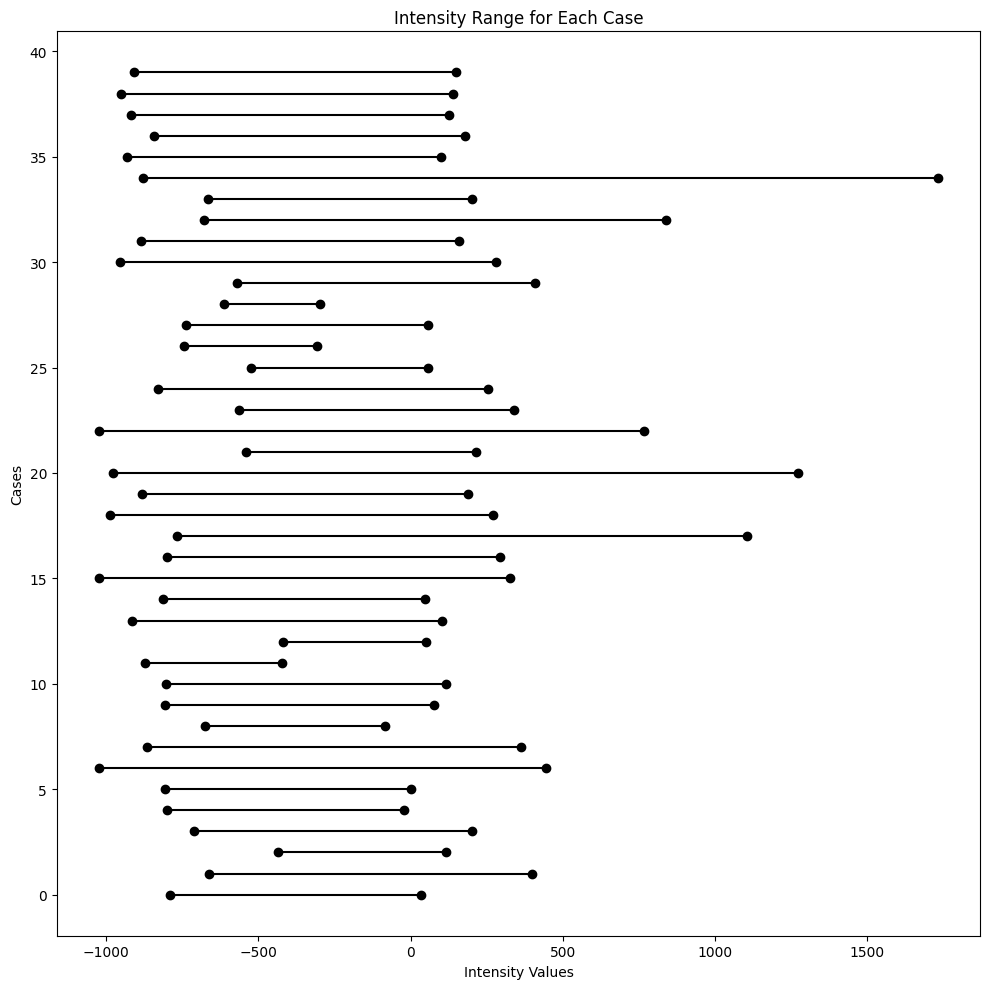

In [13]:

fig, ax = plt.subplots(figsize=(10, 10))

# plot a line from [min_intensity, case] to [max_intensity, case], same case y axis
for case, min_intensity, max_intensity in range_values:
    ax.plot([min_intensity, max_intensity], [case, case], marker='o',color='black') 

ax.set_xlabel('Intensity Values')
ax.set_ylabel('Cases')
ax.set_title('Intensity Range for Each Case')

plt.tight_layout()
plt.show()

I thought it would be interesting to plot a histogram too to visualise the distribution of min and max values

-1024.0
1733.0


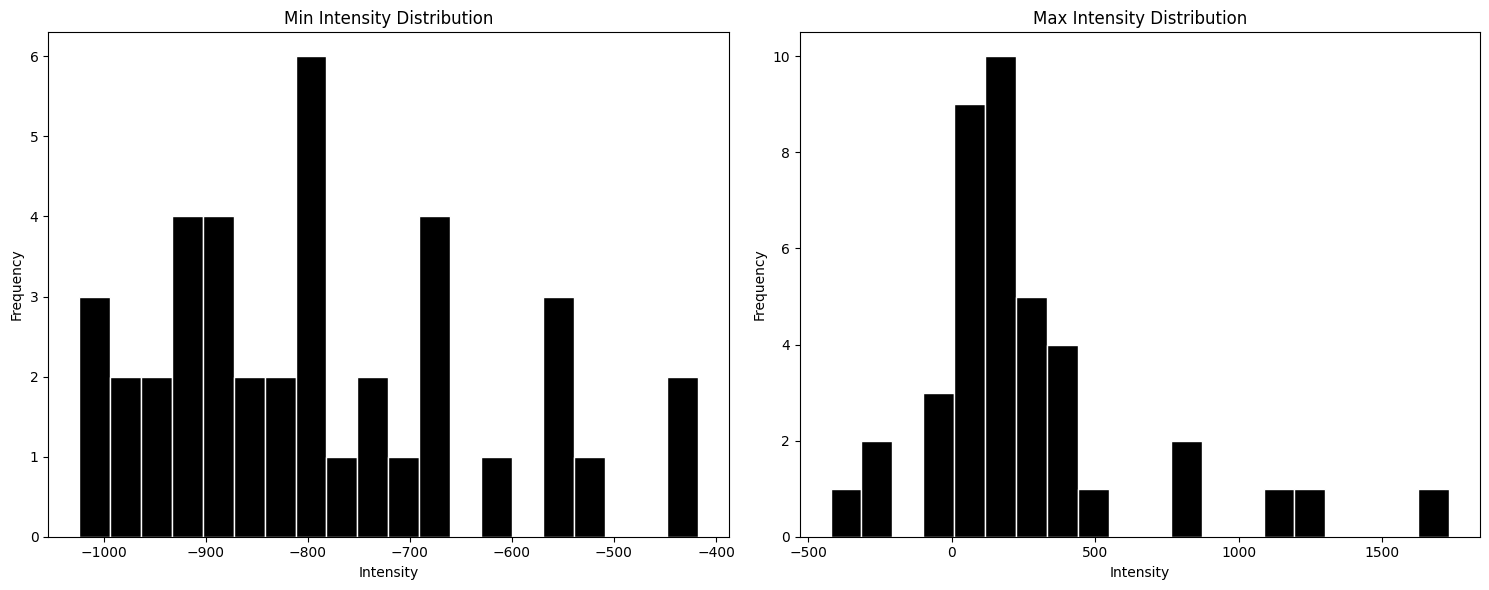

In [17]:
#umnpack min and max value from tuples in range
min_values = [min_val for _, min_val, _ in range_values]
max_values = [max_val for _, _, max_val in range_values]
print(min(min_values))
print(max(max_values))

fig, ax = plt.subplots(1, 2, figsize=(15, 6))

#minimum intensity
ax[0].hist(min_values, bins=20, color='black', edgecolor='white')
ax[0].set_title('Min Intensity Distribution')
ax[0].set_xlabel('Intensity')
ax[0].set_ylabel('Frequency')

#maximum intensity
ax[1].hist(max_values, bins=20, color='black', edgecolor='white')
ax[1].set_title('Max Intensity Distribution')
ax[1].set_xlabel('Intensity')
ax[1].set_ylabel('Frequency')
plt.tight_layout()
plt.show()


To answer the final part of the questions 'Compute the value of each feature on each patient’s nodule.' and 'Which of those features would you use to classify between the benign and malignant lesions and why?', I will need to know evaluate the radiomic features for how well they can predict the malignant and benign tumors. Since I have the true labels in labels.csv, I will load them in with pandas.

In [18]:
df = pd.read_csv("labels.csv")

# Recode: 1 → 0 (benign), 2 or 3 → 1 (malignant)

# In labels.csv, label 2 and 3 are malignant. 
# For ease of computations, I will label 2 and 3 as 1, and 1 as 0.
df["Label"] = df["Diagnosis"].apply(lambda x: 0 if x == 1 else 1)


Now I will compute the radiomic features. I will keep note of the case number so I can match it back to the labels.csv file.

In [19]:
energy_values = []
mad_values = []
uniformity_values = []

for case_number, values in voxel_values:
    energy = energyfunc(values)
    mad = madfunc(values)
    uniform = uniformityfunc(values, bins=64)
    energy_values.append((case_number, energy))
    mad_values.append((case_number, mad))
    uniformity_values.append((case_number, uniform))

# I will map it into the corresponding case number in the labels.csv file
energy_dict = dict(energy_values)
df["Uniformity"] = df["ID"].map(energy_dict)

mad_dict = dict(mad_values)
df["MAD"] = df["ID"].map(mad_dict)

uniformity_dict = dict(uniformity_values)
df["Uniformity"] = df["ID"].map(uniformity_dict)

    

Here I am inspecting what my dataframe looks like! I am seeing that there are 20/40 malignant cases. To make a prediction with Uniformity and MAD on what is classified as malignant, I will need a metric. Literature say that non - homogeneity (low uniformity or high MAD) is a sign of malignancy. since 50% of the cases are malignant, I will assign the bottom 50% percentile and upper 50% of MAD to being my predicted malignant cases.

In [20]:
print(df)
malignant_count = df["Label"].sum()
print(f"Number of malignant cases: {malignant_count} of {len(df)} total cases")

#50th percentile thresholds for uniformity and mad
uniformity_thresh = df["Uniformity"].quantile(0.5)
mad_thresh = df["MAD"].quantile(0.5)

# make predictions
df["Pred_Uniformity"] = (df["Uniformity"] < uniformity_thresh).astype(int)
df["Pred_MAD"] = (df["MAD"] > mad_thresh).astype(int)


    ID  Diagnosis  Label  Uniformity         MAD
0    0          2      1    0.060095  189.503849
1    1          3      1    0.146536  106.039925
2    2          2      1    0.359960   30.289575
3    3          1      0    0.062723  197.117147
4    4          3      1    0.079335  122.899089
5    5          1      0    0.060263  203.623394
6    6          2      1    0.070675  220.788669
7    7          2      1    0.548563   56.717060
8    8          1      0    0.101125  105.551653
9    9          1      0    0.053855  235.489366
10  10          1      0    0.064815  274.027778
11  11          3      1    0.224871   47.669994
12  12          1      0    0.102557  118.830221
13  13          1      0    0.071881  203.773130
14  14          1      0    0.193538  165.197182
15  15          2      1    0.089149  161.470332
16  16          2      1    0.115554  140.447734
17  17          1      0    0.051429  391.402449
18  18          1      0    0.046022  332.641816
19  19          2   

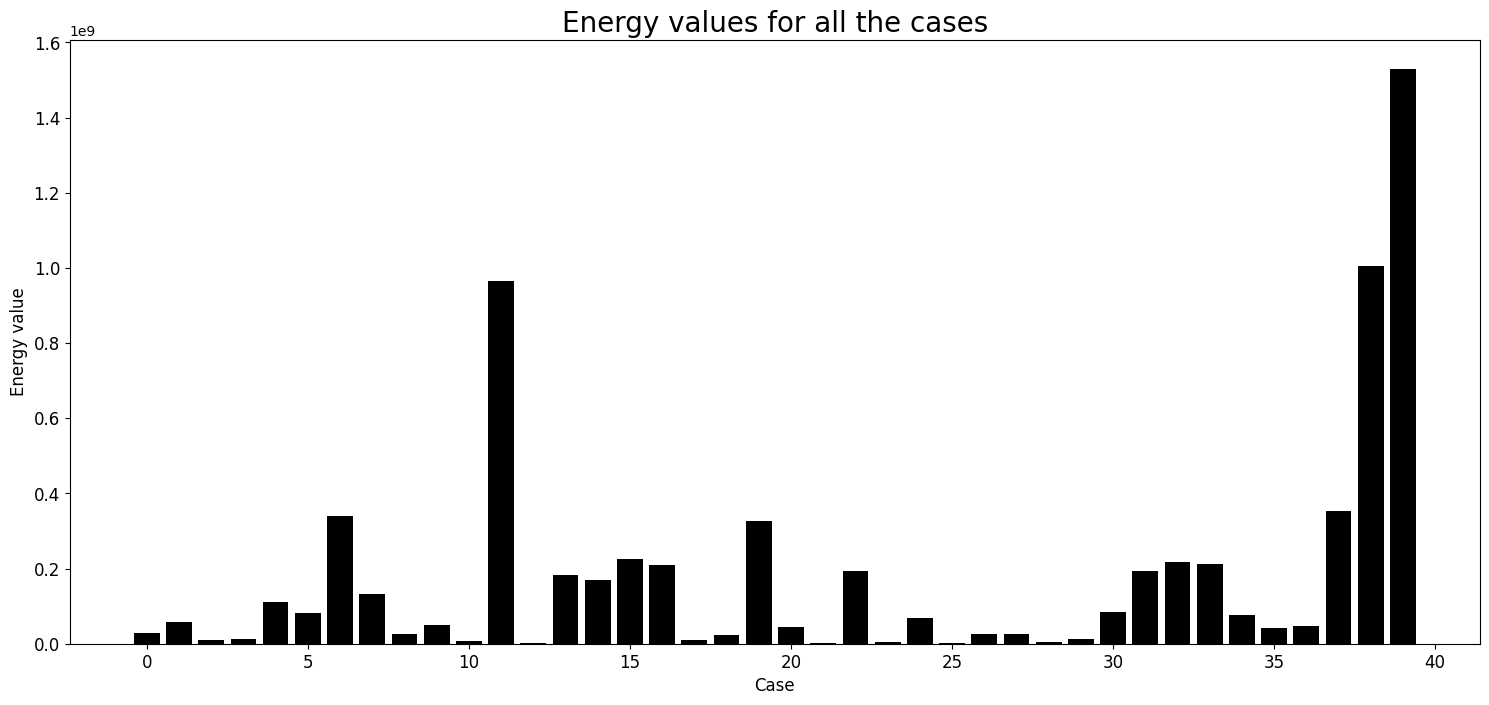

In [21]:

fig, ax = plt.subplots(figsize=(15, 7))

# Loop over the data to plot each case
for case, energy in energy_values:
    ax.bar(case, energy,color='black') 

ax.set_xlabel('Case', fontsize=12)
ax.set_ylabel('Energy value', fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.title("Energy values for all the cases",fontsize=20)
plt.show()

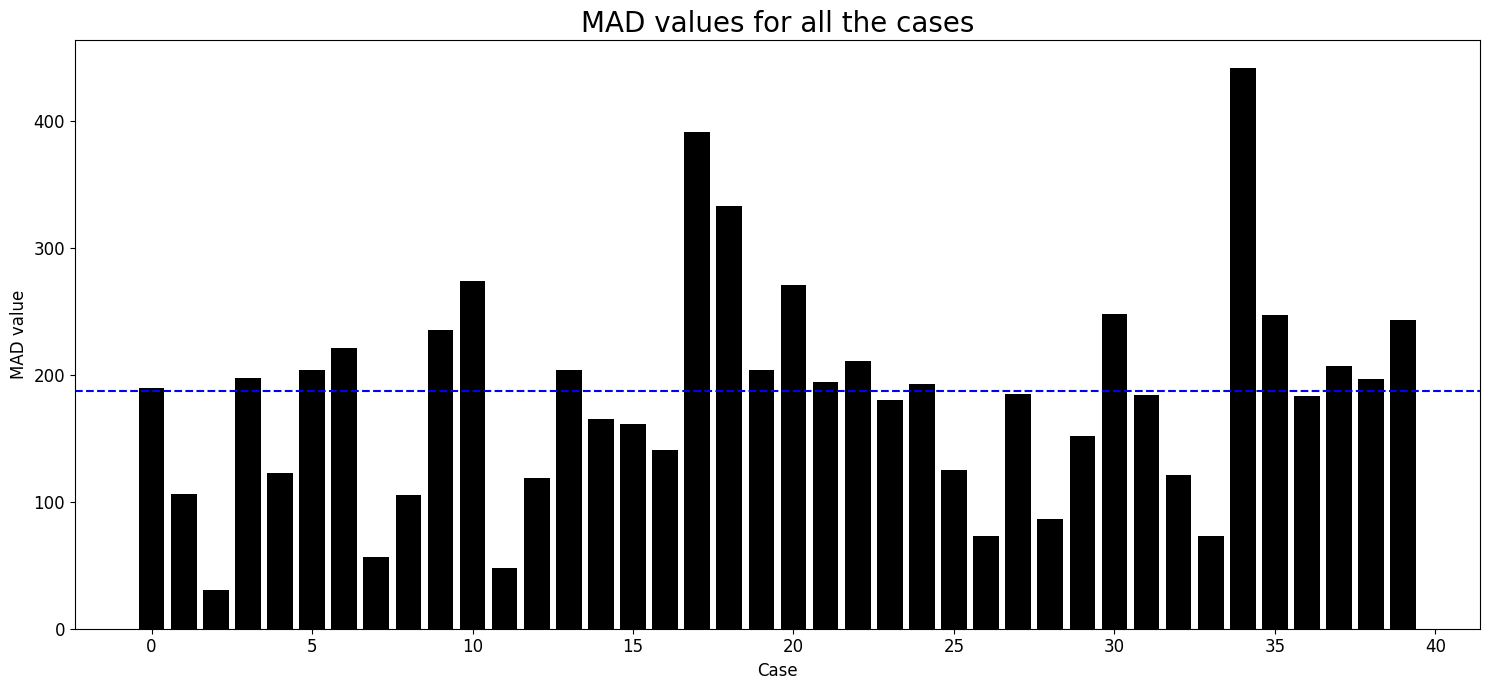

In [22]:
fig, ax = plt.subplots(figsize=(15, 7))

for case, mad in mad_values:
    ax.bar(case, mad,color='black')

ax.set_xlabel('Case', fontsize=12)
ax.set_ylabel('MAD value', fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.axhline(mad_thresh, color='blue', linestyle='--', label=f"50th percentile = {mad_thresh:.3f}")
#plotting a line, such that cases above the line are classified as malignant.
plt.title("MAD values for all the cases",fontsize=20)
plt.tight_layout()
plt.show()

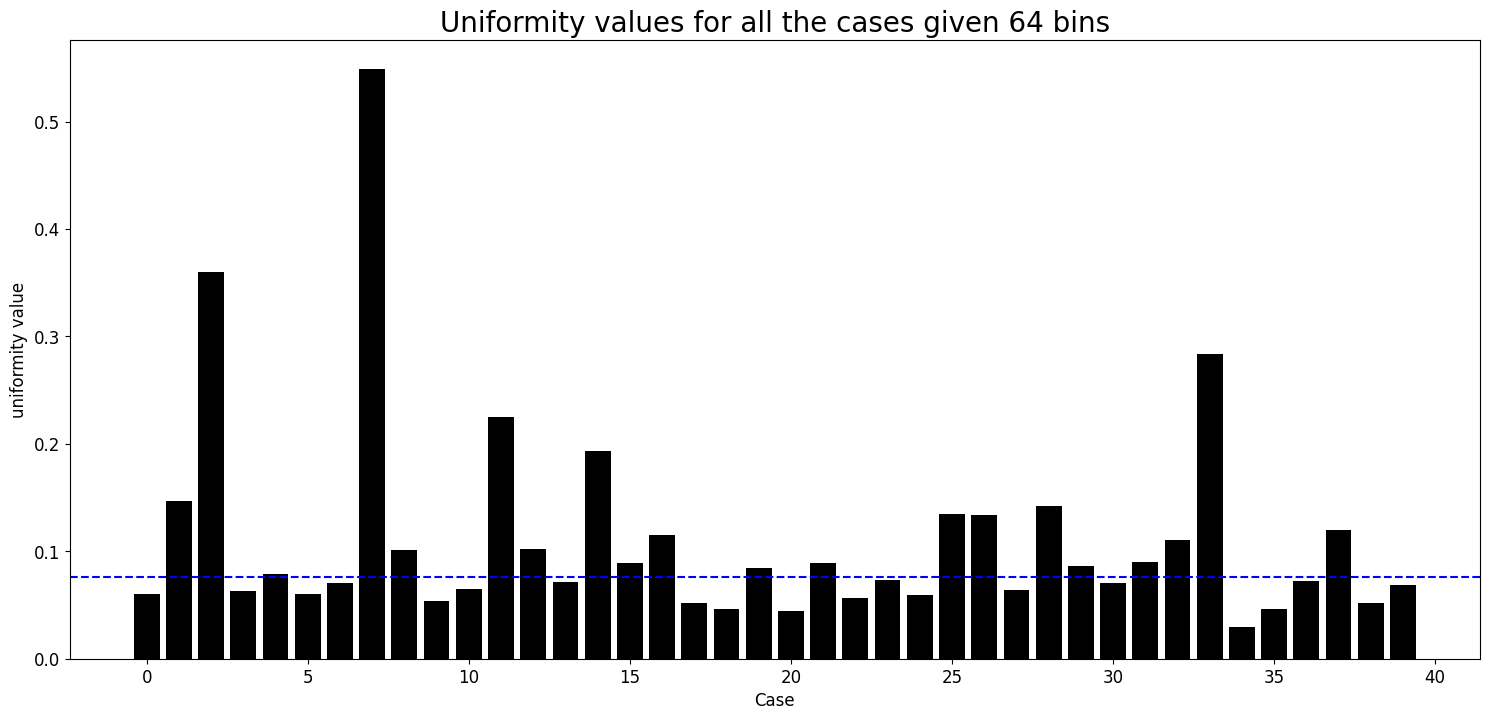

In [23]:

fig, ax = plt.subplots(figsize=(15, 7))

for case, uni in uniformity_values:
    ax.bar(case, uni ,color='black') 

ax.set_xlabel('Case', fontsize=12)
ax.set_ylabel('uniformity value', fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.axhline(uniformity_thresh, color='blue', linestyle='--', label=f"50th percentile = {uniformity_thresh:.3f}")
#plotting a line, such that cases below the line are classified as malignant.
plt.title("Uniformity values for all the cases given 64 bins",fontsize=20)
plt.show()

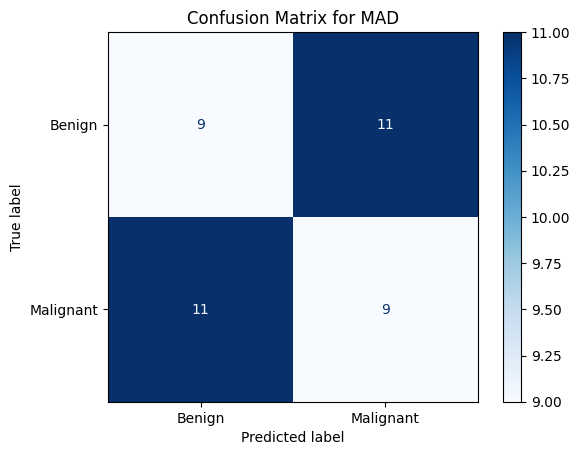

In [24]:
#mad
mad_cm = confusion_matrix(y_true=df["Label"], y_pred=df["Pred_MAD"])
display_mad= ConfusionMatrixDisplay(confusion_matrix=mad_cm, display_labels=["Benign", "Malignant"])
display_mad.plot(cmap='Blues', values_format='d')  # 'd' = integer formatting

plt.title("Confusion Matrix for MAD")
plt.show()


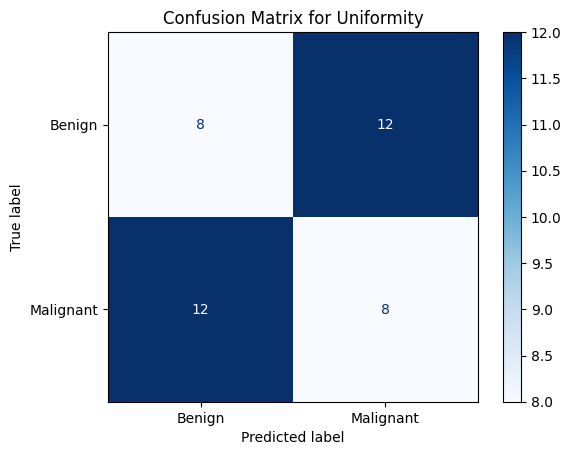

In [25]:
#uniformity
uni_cm = confusion_matrix(y_true=df["Label"], y_pred=df["Pred_Uniformity"])

uni_disp = ConfusionMatrixDisplay(confusion_matrix=uni_cm, display_labels=["Benign", "Malignant"])
uni_disp.plot(cmap='Blues', values_format='d')  # 'd' = integer formatting

plt.title("Confusion Matrix for Uniformity")
plt.show()
